In [1]:
from Tusc5ImageUtils import *
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib inline
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")
###
from cellpose import utils, io, plot, models
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Directory ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [3]:
f = nd2.ND2File(img_path)
image = f.asarray()

DAPI_stack = to_8bit(image[:,0,:,:].copy())
eGFP_stack = to_8bit(image[:,1,:,:].copy())
WGA_stack = to_8bit(image[:,2,:,:].copy())

mp_DAPI = max_proj(DAPI_stack)

model = models.CellposeModel(pretrained_model=model_path_dapi)
masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


(-0.5, 1023.5, 1023.5, -0.5)

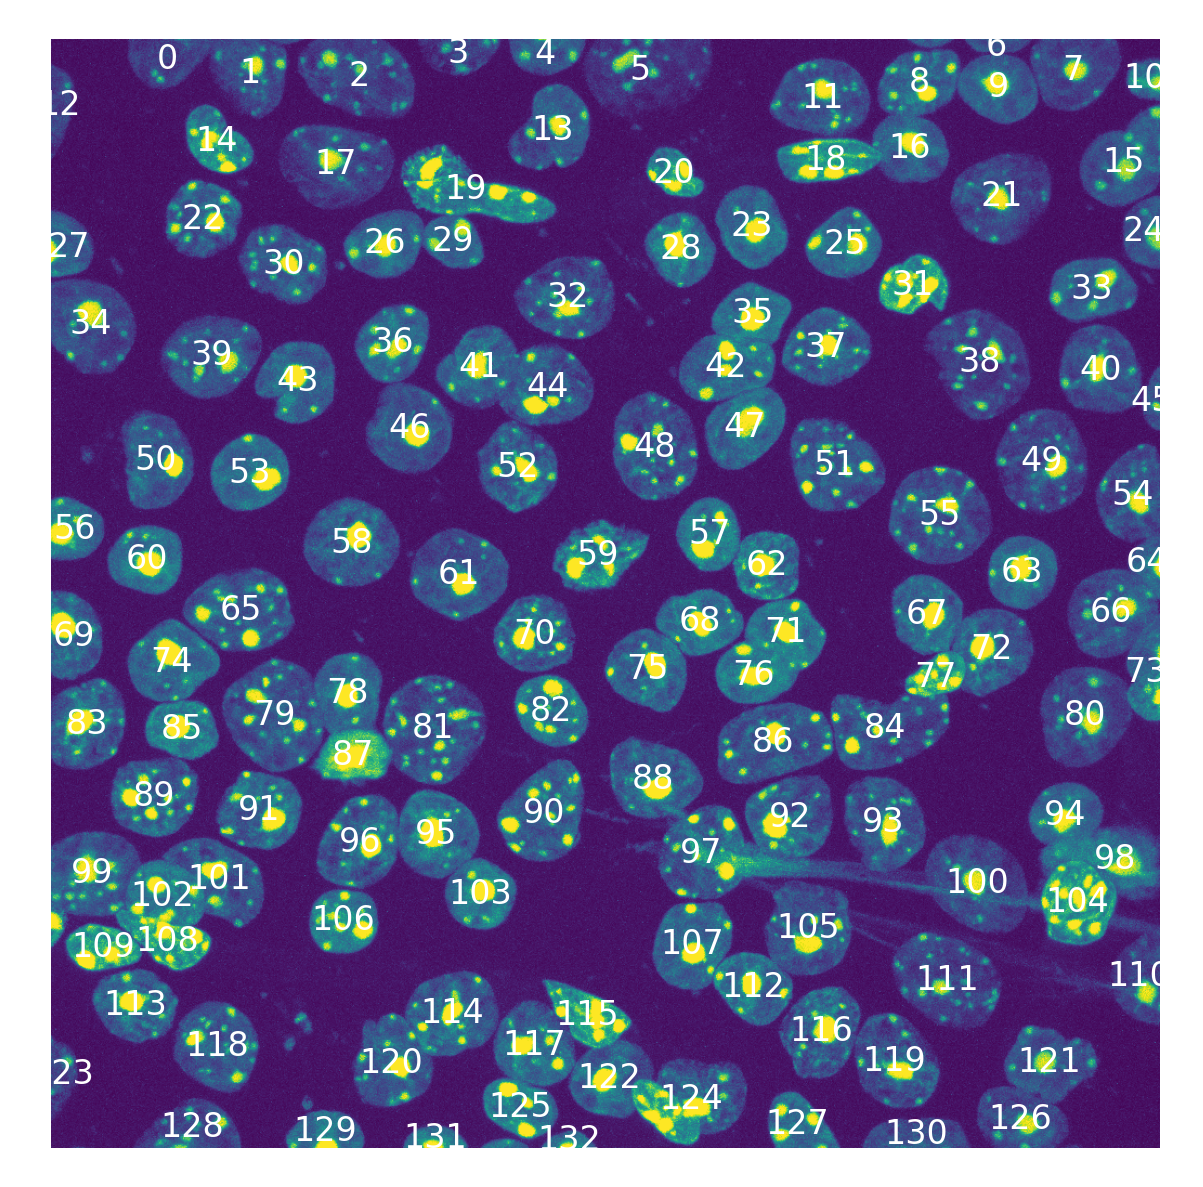

In [4]:
DAPI_coords = get_nuclei_position(masks)
plt.imshow(mp_DAPI)
plot_maskids(DAPI_coords, text_color = 'white', font_size = 8)
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

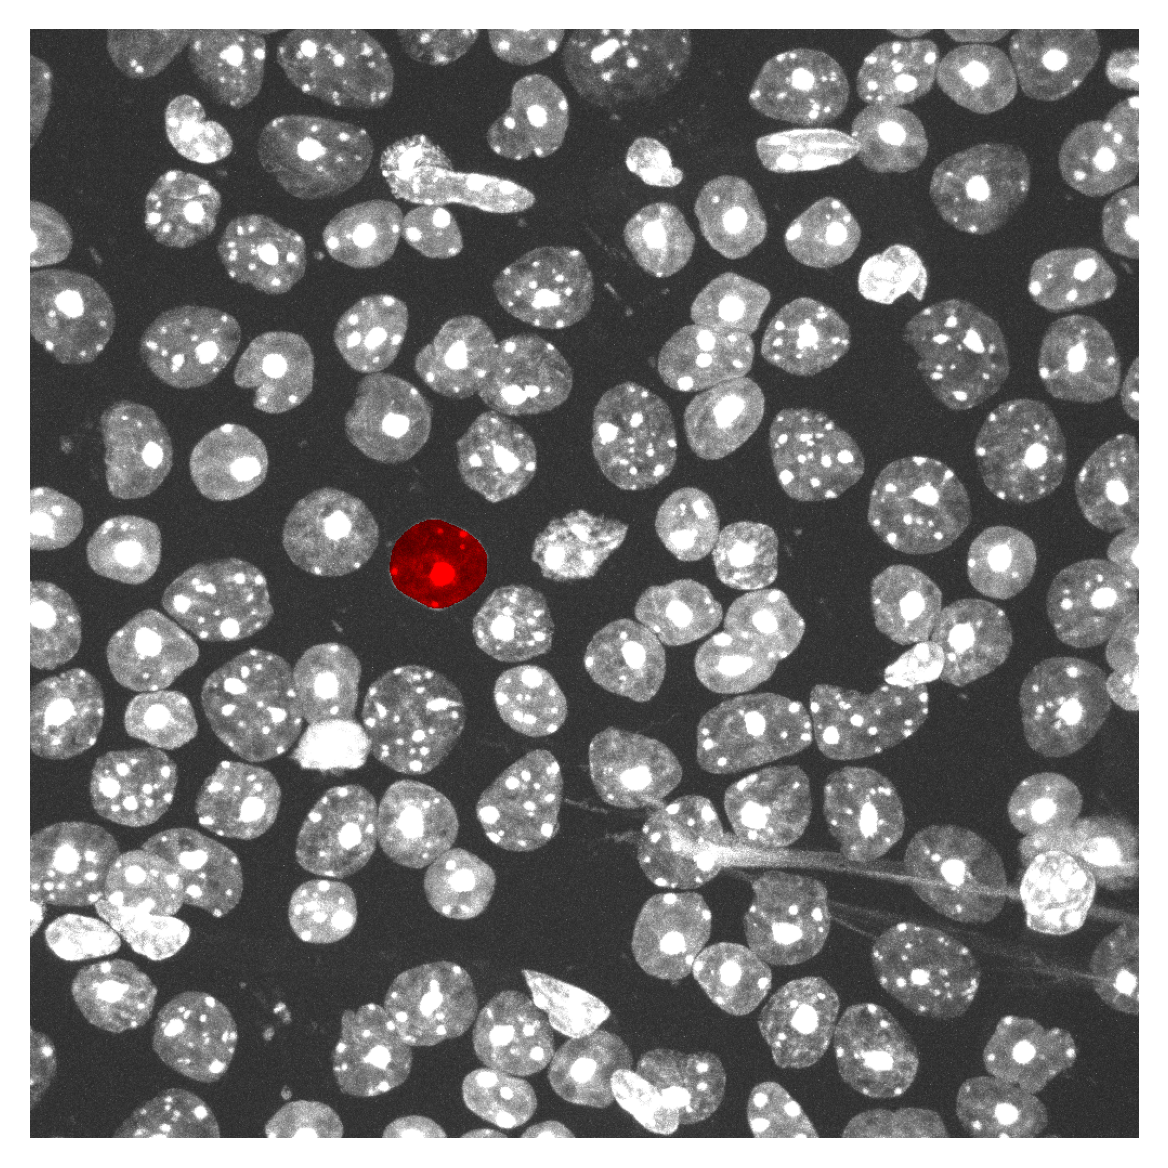

In [5]:
single_mask = masks.copy() == 62
plt.imshow(plot.mask_overlay(mp_DAPI, single_mask.astype(int)))
plt.axis('off')

# Reverse Max Proj

In [6]:
import numpy as np
from skimage import io, measure, color

# Load the binary mask image
#mask = io.imread('path_to_your_mask_image.png', as_gray=True)

# Ensure the image is binary (0 and 1)
#binary_mask = mask > 0.5

# Label connected regions in the binary image
labeled_mask = measure.label(single_mask)

# Measure region properties
regions = measure.regionprops(labeled_mask)

# Assume the largest region is the object of interest
largest_region = max(regions, key=lambda r: r.area)

# Get the equivalent diameter
diameter = largest_region.equivalent_diameter

print(f'The diameter of the mask is: {diameter} pixels')


The diameter of the mask is: 84.29679649409545 pixels


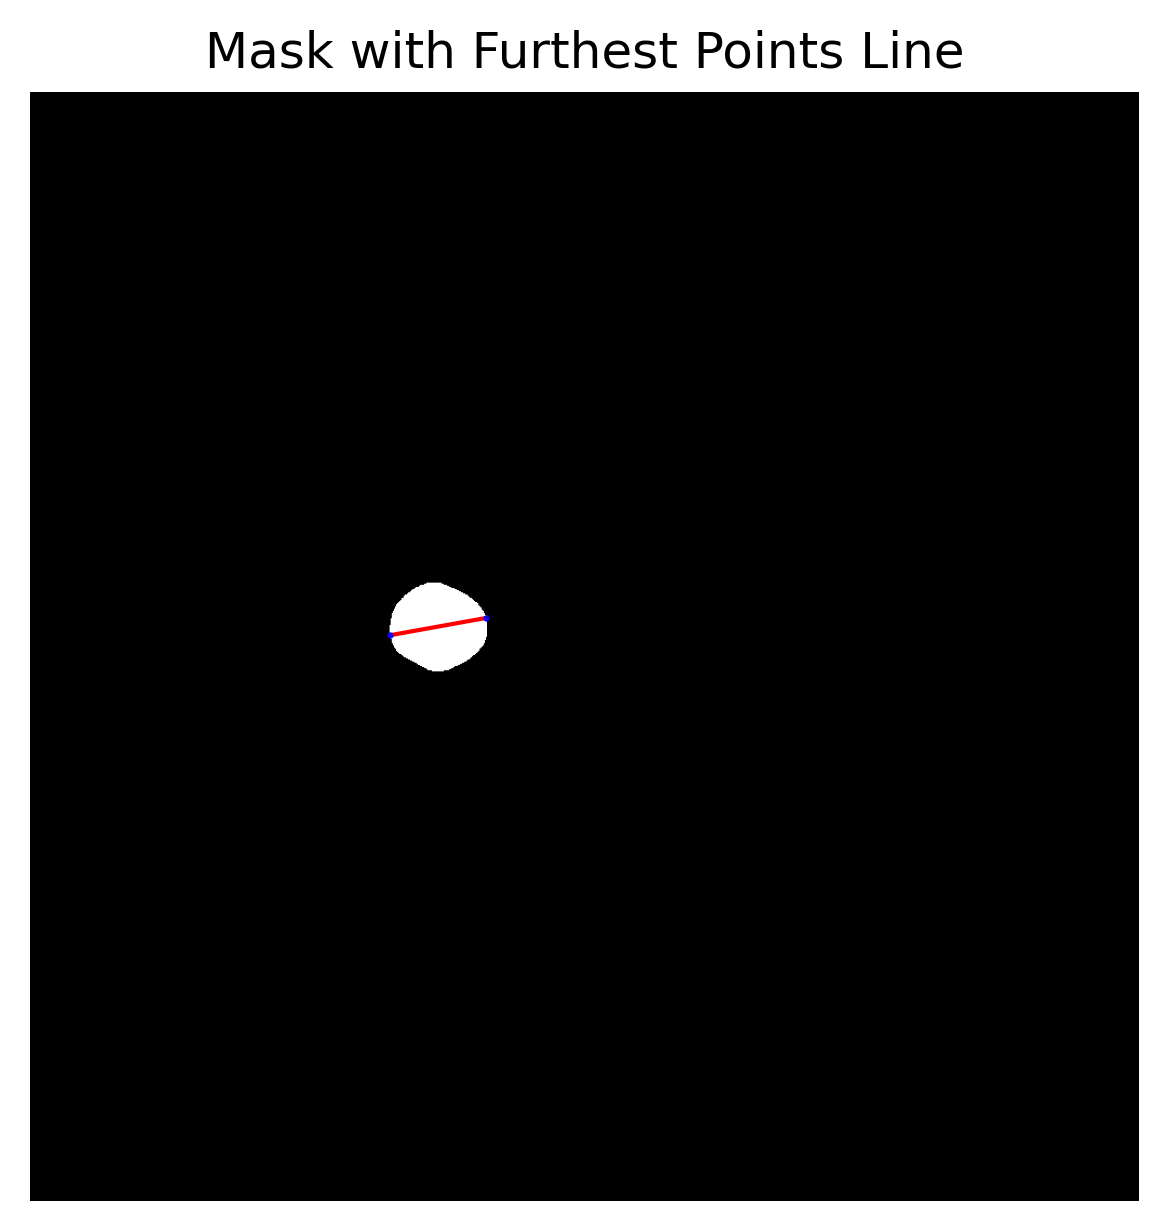

In [7]:
import numpy as np
from skimage import io, measure
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance_matrix

# Load the binary mask image
#single_mask = io.imread('path_to_your_mask_image.png', as_gray=True)

# Ensure the image is binary (0 and 1)
#binary_mask = single_mask > 0.5

# Label connected regions in the binary image
labeled_mask = measure.label(single_mask)

# Measure region properties
regions = measure.regionprops(labeled_mask)

# Assume the largest region is the object of interest
largest_region = max(regions, key=lambda r: r.area)

# Get the coordinates of the largest region's convex hull
coords = largest_region.coords
hull = ConvexHull(coords)

# Extract the points from the convex hull
hull_points = coords[hull.vertices]

# Compute all pairwise distances between hull points
distances = distance_matrix(hull_points, hull_points)

# Find the pair of points with the maximum distance
max_dist_indices = np.unravel_index(np.argmax(distances), distances.shape)
point1 = hull_points[max_dist_indices[0]]
point2 = hull_points[max_dist_indices[1]]

# Create a figure and axis
fig, ax = plt.subplots()

# Display the mask
ax.imshow(single_mask, cmap='gray')

# Plot the furthest points and the line connecting them
ax.plot([point1[1], point2[1]], [point1[0], point2[0]], 'r-', linewidth=1)
ax.plot(point1[1], point1[0], 'bo', markersize = .5)
ax.plot(point2[1], point2[0], 'bo', markersize = .5)

# Set title and display the plot
ax.set_title(f'Mask with Furthest Points Line')
plt.axis('off')
plt.show()


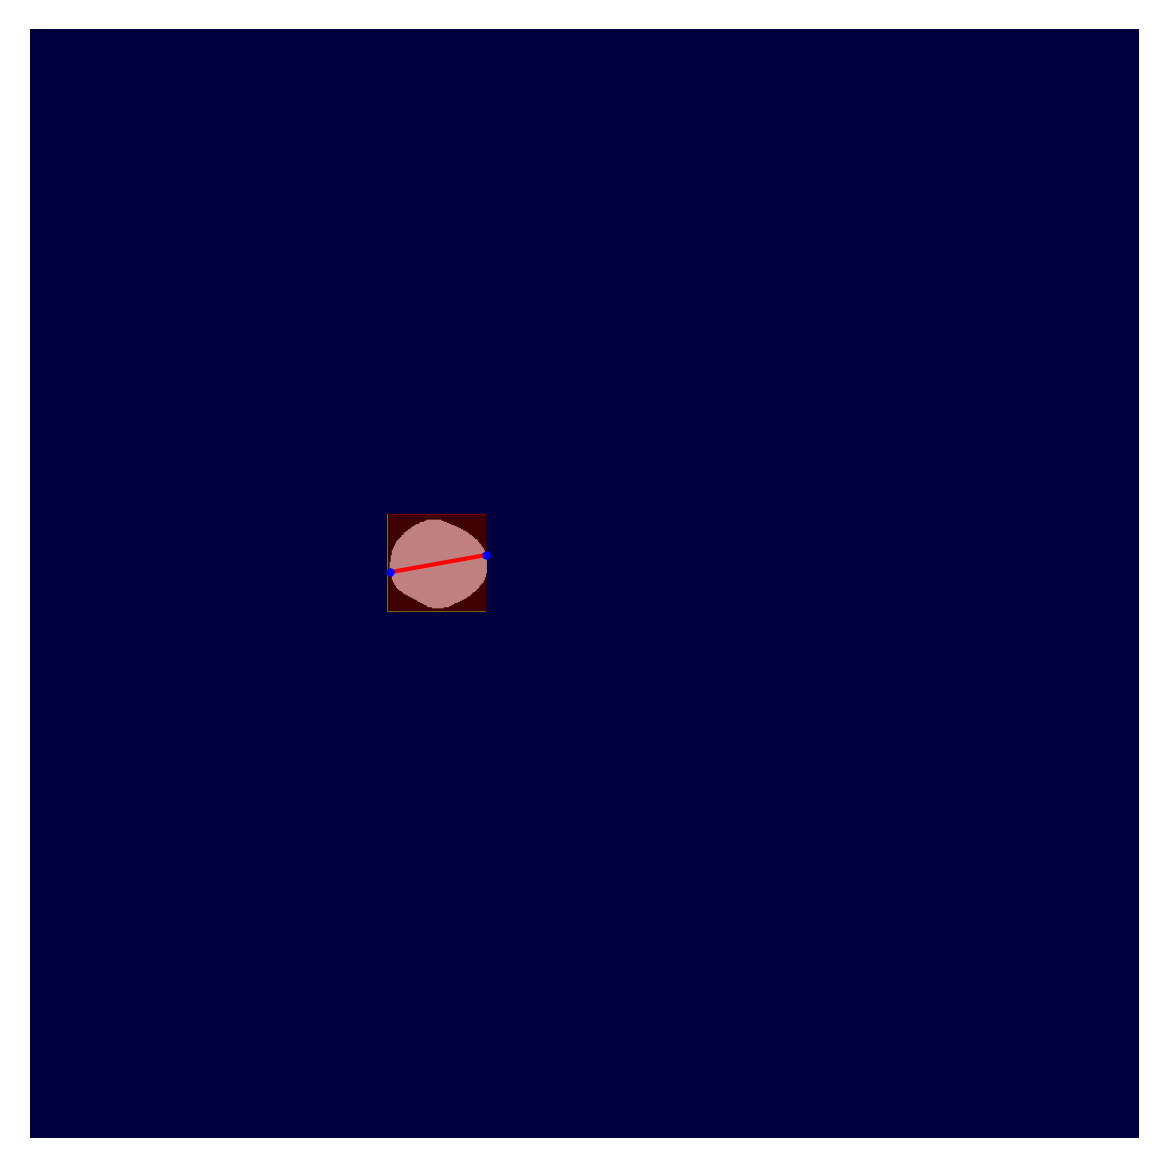

In [8]:
import numpy as np
from skimage import io, measure
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance_matrix

# Load the binary mask image
# single_mask = io.imread('path_to_your_mask_image.png', as_gray=True)

# Ensure the image is binary (0 and 1)
# binary_mask = single_mask > 0.5

# Label connected regions in the binary image
labeled_mask = measure.label(single_mask)

# Measure region properties
regions = measure.regionprops(labeled_mask)

# Assume the largest region is the object of interest
largest_region = max(regions, key=lambda r: r.area)

# Get the coordinates of the largest region's convex hull
coords = largest_region.coords
hull = ConvexHull(coords)

# Extract the points from the convex hull
hull_points = coords[hull.vertices]

# Compute all pairwise distances between hull points
distances = distance_matrix(hull_points, hull_points)

# Find the pair of points with the maximum distance
max_dist_indices = np.unravel_index(np.argmax(distances), distances.shape)
point1 = hull_points[max_dist_indices[0]]
point2 = hull_points[max_dist_indices[1]]

# Get the equivalent diameter and centroid
diameter = np.linalg.norm(point1 - point2)
centroid = largest_region.centroid

# Increase the diameter by 50%
new_diameter = diameter * 1

# Calculate the size of the square side
square_side = new_diameter

# Calculate the top-left and bottom-right coordinates of the square
top_left = (int(centroid[0] - square_side / 2), int(centroid[1] - square_side / 2))
bottom_right = (int(centroid[0] + square_side / 2), int(centroid[1] + square_side / 2))

# Ensure the coordinates are within the image bounds
top_left = (max(top_left[0], 0), max(top_left[1], 0))
bottom_right = (min(bottom_right[0], single_mask.shape[0]), min(bottom_right[1], single_mask.shape[1]))

# Create a new mask with the square
new_mask = np.zeros_like(single_mask)
new_mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1

# Create a figure and axis
#fig, ax = plt.subplots(figsize=(6, 6))

# Display the original mask with the overlaid square mask
plt.imshow(np.zeros_like(single_mask), cmap='gray')  # Black background
plt.imshow(single_mask, cmap='gray', alpha=1.0)     # Original mask with transparency
plt.imshow(new_mask, cmap='jet', alpha=0.5)         # New mask with transparency

# Plot the furthest points and the line connecting them
plt.plot([point1[1], point2[1]], [point1[0], point2[0]], 'r-', linewidth=1)
plt.plot(point1[1], point1[0], 'bo', markersize=1)
plt.plot(point2[1], point2[0], 'bo', markersize=1)

plt.axis('off')

plt.show()


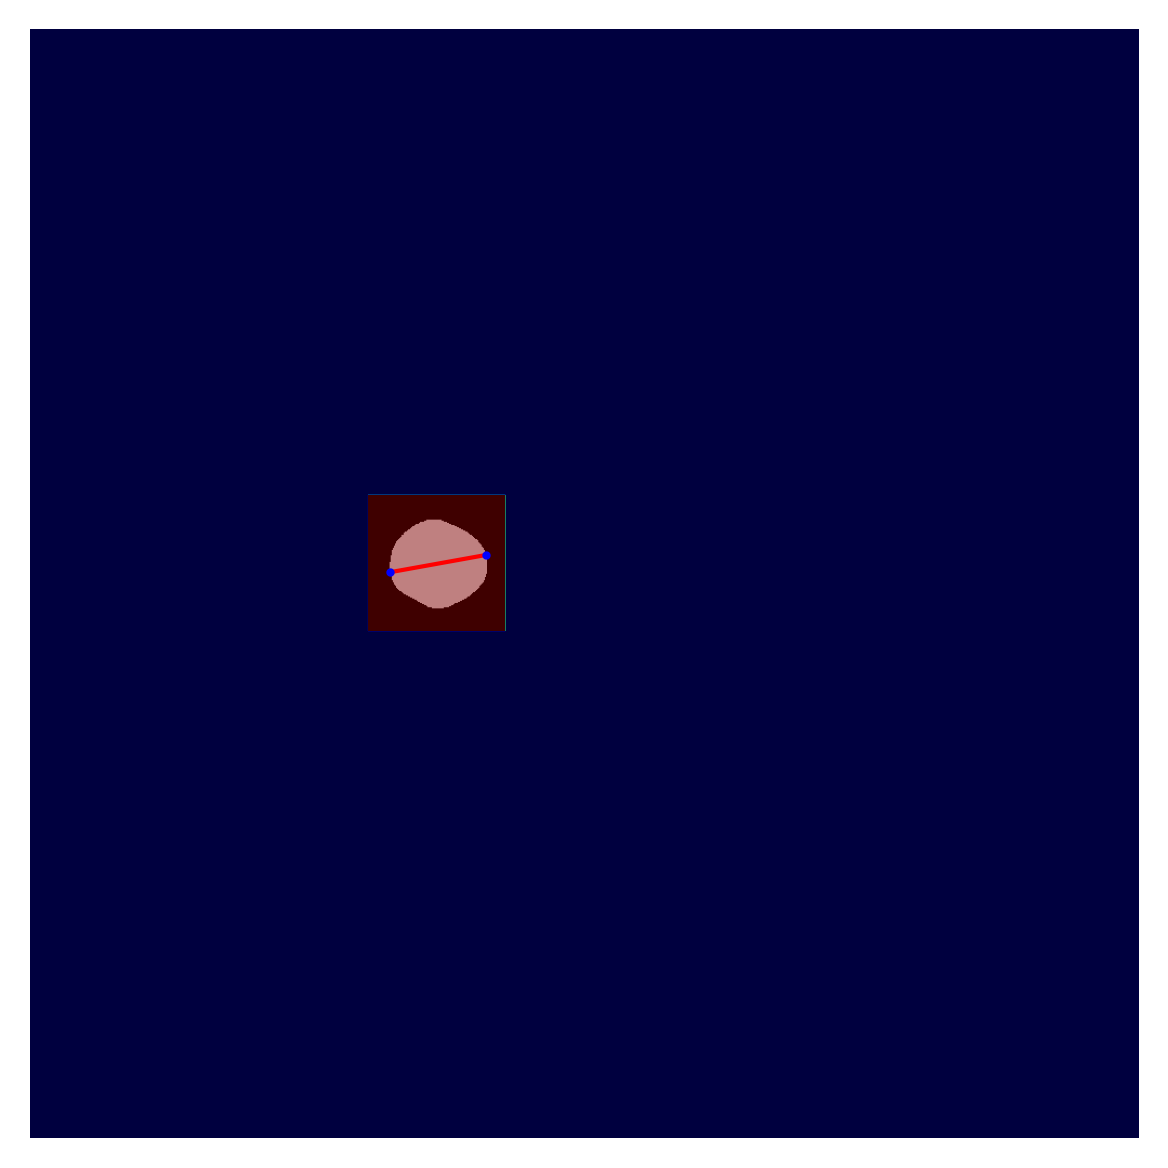

In [9]:
import numpy as np
from skimage import io, measure
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance_matrix

# Load the binary mask image
# single_mask = io.imread('path_to_your_mask_image.png', as_gray=True)

# Ensure the image is binary (0 and 1)
# binary_mask = single_mask > 0.5

# Label connected regions in the binary image
labeled_mask = measure.label(single_mask)

# Measure region properties
regions = measure.regionprops(labeled_mask)

# Assume the largest region is the object of interest
largest_region = max(regions, key=lambda r: r.area)

# Get the coordinates of the largest region's convex hull
coords = largest_region.coords
hull = ConvexHull(coords)

# Extract the points from the convex hull
hull_points = coords[hull.vertices]

# Compute all pairwise distances between hull points
distances = distance_matrix(hull_points, hull_points)

# Find the pair of points with the maximum distance
max_dist_indices = np.unravel_index(np.argmax(distances), distances.shape)
point1 = hull_points[max_dist_indices[0]]
point2 = hull_points[max_dist_indices[1]]

# Get the equivalent diameter and centroid
diameter = np.linalg.norm(point1 - point2)
centroid = largest_region.centroid

# Increase the diameter by 50%
new_diameter = diameter * 1.40

# Calculate the size of the square side
square_side = new_diameter

# Calculate the top-left and bottom-right coordinates of the square
top_left = (int(centroid[0] - square_side / 2), int(centroid[1] - square_side / 2))
bottom_right = (int(centroid[0] + square_side / 2), int(centroid[1] + square_side / 2))

# Ensure the coordinates are within the image bounds
top_left = (max(top_left[0], 0), max(top_left[1], 0))
bottom_right = (min(bottom_right[0], single_mask.shape[0]), min(bottom_right[1], single_mask.shape[1]))

# Create a new mask with the square
new_mask = np.zeros_like(single_mask)
new_mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1

# Create a figure and axis
#fig, ax = plt.subplots(figsize=(6, 6))

# Display the original mask with the overlaid square mask
plt.imshow(np.zeros_like(single_mask), cmap='gray')  # Black background
plt.imshow(single_mask, cmap='gray', alpha=1.0)     # Original mask with transparency
plt.imshow(new_mask, cmap='jet', alpha=0.5)         # New mask with transparency

# Plot the furthest points and the line connecting them
plt.plot([point1[1], point2[1]], [point1[0], point2[0]], 'r-', linewidth=1)
plt.plot(point1[1], point1[0], 'bo', markersize=1)
plt.plot(point2[1], point2[0], 'bo', markersize=1)

plt.axis('off')

plt.show()


In [10]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
from skimage import measure

def square_mask(mask, perc_increase: int = 40):
    """
    Create a square mask around the largest region of interest in a binary mask.
    Ensures the mask stays within the bounds of the image.

    Parameters:
    - mask: 2D numpy array (binary mask).
    - perc_increase: Percentage to increase the diameter of the square.

    Returns:
    - new_mask: 2D numpy array with the square mask.
    """
    # Label connected regions in the binary image
    labeled_mask = measure.label(mask)

    # Measure region properties
    regions = measure.regionprops(labeled_mask)

    # Assume the largest region is the object of interest
    largest_region = max(regions, key=lambda r: r.area)

    # Get the coordinates of the largest region's convex hull
    coords = largest_region.coords
    hull = ConvexHull(coords)

    # Extract the points from the convex hull
    hull_points = coords[hull.vertices]

    # Compute all pairwise distances between hull points
    distances = distance_matrix(hull_points, hull_points)

    # Find the pair of points with the maximum distance
    max_dist_indices = np.unravel_index(np.argmax(distances), distances.shape)
    point1 = hull_points[max_dist_indices[0]]
    point2 = hull_points[max_dist_indices[1]]

    # Get the equivalent diameter and centroid
    diameter = np.linalg.norm(point1 - point2)
    centroid = largest_region.centroid

    # Increase the diameter by however much
    new_diameter = diameter * (1 + perc_increase / 100)

    # Calculate the size of the square side
    square_side = new_diameter

    # Calculate the top-left and bottom-right coordinates of the square
    top_left = (int(centroid[0] - square_side / 2), int(centroid[1] - square_side / 2))
    bottom_right = (int(centroid[0] + square_side / 2), int(centroid[1] + square_side / 2))

    # Ensure the coordinates are within the image bounds
    top_left = (max(top_left[0], 0), max(top_left[1], 0))
    bottom_right = (min(bottom_right[0], mask.shape[0]), min(bottom_right[1], mask.shape[1]))

    # Create a new mask with the square
    new_mask = np.zeros_like(mask)
    new_mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1

    return new_mask

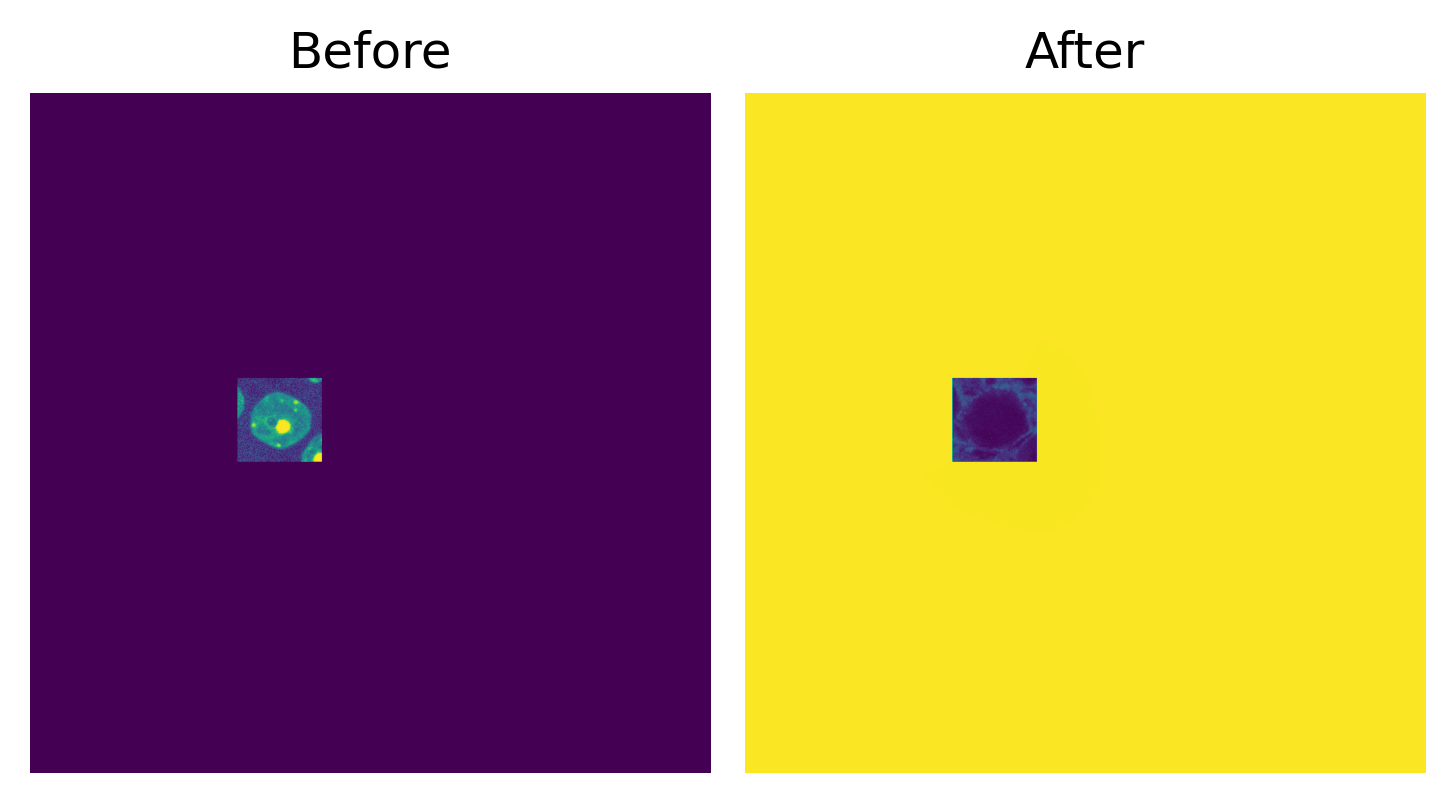

In [11]:
test_stack1 = DAPI_stack.copy()
test_stack1 = auto_brightness_contrast(max_proj(test_stack1[39:46,:,:]) * square_mask(single_mask))

test_stack2 = WGA_stack.copy()
test_stack2 = auto_brightness_contrast(max_proj(~test_stack2[39:46,:,:]) * square_mask(single_mask))

plot_2images(test_stack1, ~test_stack2, auto_bc = True)

# Result

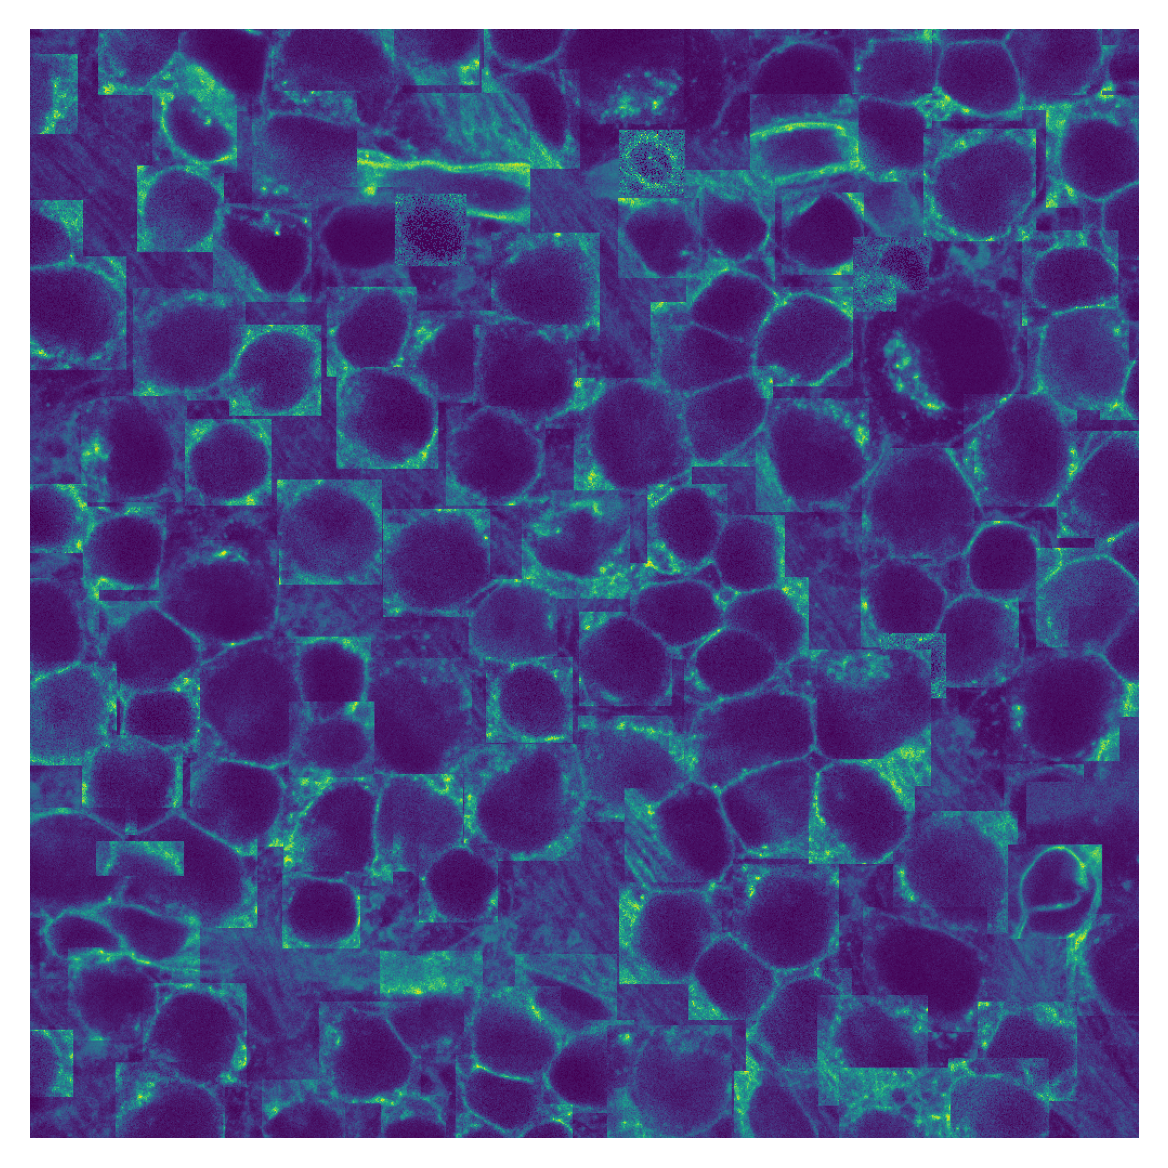

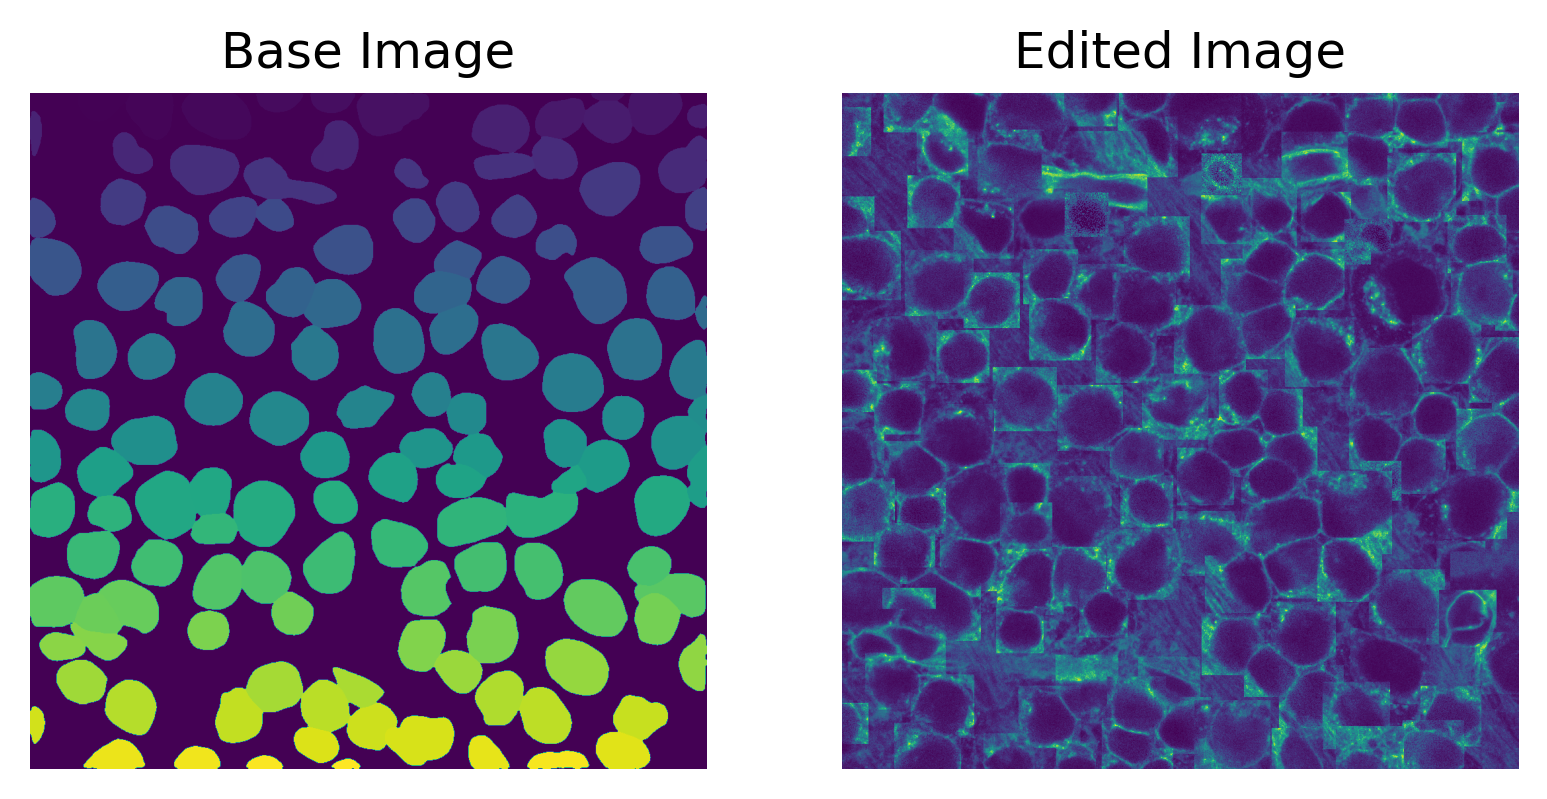

In [18]:
tx = WGA_stitcher(DAPI_stack, WGA_stack, masks, .15)
plot_before_after(masks,tx)